## BASEBALL PITCH PREDICTIONS

Baseball has long been one of America’s oldest and most popular sports. In addition to its long history, baseball has been on the forefront of the sports “analytics” movement. This analytical approach, called sabermetrics, was pioneered in the 1970’s and 1980’s by Bill James and others, and was brought to prominence in the early 2000’s by Billy Beane’s Oakland Athletics, chronicled by Michael Lewis’ book Moneyball. The history of analytics within the sport, combined with the discrete nature of the game — individual pitches and game events — make baseball data readily available and accessible. One such data source is MLB’s publicly available, PITCHf/x database, in which data is gathered on a per pitch basis using cameras and sensors throughout all 30 major league ballparks.

Throughout a game, each team’s pitchers will throw the ball over 100 times. Not only do each pitcher hold and throw the ball different from one another, but an individual pitcher often throws the ball with different grips and arm mechanics causing the ball to move differently over the 60 feet, 6 inches between the pitching mound and home plate. The variation between pitch speed, movement, and location, is the primary way a pitcher is able to gain an advantage over the batter. The mix of pitches a player throws varies within games, as well as throughout a season. Should the batter know what pitch type will be thrown next, this advantage is reduced significantly. The recent sign stealing scandal involving the Houston Astros revolves around illegally intercepting pitch signs, and highlights the market for this information.

**Using machine learning techniques, I wondered was it possible to predict what type of pitch would come next?**

For the sake of this blog post, and as a starting point of this analysis, I have limited my dataset to just one pitcher, Jose Berrios. I chose to focus on Berrios for a few reasons. First as a “proof of concept” that these ideas and techniques can be applied to other pitchers (see further development section). Second, Berrios is a starting pitcher resulting in more pitches thrown throughout an individual game, and more data than many other pitchers. Third, Berrios varies his pitches between four different pitch types, causing there to be greater gains from correct predictions.

## SETUP

---



In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pybaseball

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pybaseball import statcast_pitcher, playerid_lookup
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

## DATA GATHERING

---



Here we are using the **pybaseball** package to gather relevant data

In [254]:
berrios_id = playerid_lookup('berrios', 'jose').loc[0, 'key_mlbam']

Gathering player lookup table. This may take a moment.


In [255]:
berrios = statcast_pitcher('2008-04-01', '2020-01-01', berrios_id)

Gathering Player Data


## DATA CLEANING

---



In [0]:
def reorder(df):
  '''
  reorders pitches in ascending order
  '''
  df = df.copy()

  df = df.reindex(index=df.index[::-1])
  df = df.reset_index(drop=True)

  return df

Here we have to remove non-standard pitch types, like pitch-outs, which occur infrequently and are typically a response to events not under the pitchers control.

In [0]:
def pitch_cleaning(df):
  '''
  cleans target ('pitch_type'), dropping NaN's (bad data) and non-standard 
  pitches
  '''
  df = df.copy()

  df = df.dropna(subset=['pitch_type'])
  
  df['pitch_type'] = df['pitch_type'].str.lower()
  remove_pitches = ['po', 'in', 'un']
  df = df[~df['pitch_type'].isin(remove_pitches)]

  return df

This function moves data about the current pitch, to a historical context, to prevent data leakage.

In [0]:
def historical_cleaning(df):
  '''
  shifts relevant historical data to prevent data leakage
  '''
  df = df.copy()

  df['previous_pitch'] = df['pitch_type'].shift(1)
  df['previous_strike'] = df['type'].shift(1) == 'S'
  df['previous_zone'] = df['zone'].shift(1)
  df = df.drop(['type', 'zone'], axis=1)
  fill_na = ['previous_pitch', 'previous_zone']
  df[fill_na] = df[fill_na].fillna(0)

  return df

## DATA PROCESSING

---


In [0]:
def total_pitches(df):
  '''
  creates column of total pitches prior to current/target pitch
  '''
  df = df.copy()

  df['pitch_total'] = df.groupby('game_date').cumcount(ascending=True)

  return df

In [0]:
def score_margin(df):
  '''
  creates column of score margin for the pitcher's team
  '''
  df = df.copy()

  df['score_margin'] = df['fld_score'] - df['bat_score']
  df = df.drop(['fld_score', 'bat_score'], axis=1)

  return df

The pitcher advantage column is encoded based on the ball-strike count. This encoding is based on baseball familiarity, and could likely be interpreted differently by different people.

In [0]:
def pitcher_advantage(df):
  '''
  creates column of pitcher advantage based on the ball/strike count
  '''
  df = df.copy()

  advantages = {'0-0':'neutral', '0-1':'ahead', '0-2':'ahead', '1-0':'neutral', 
                '1-1':'neutral', '1-2':'ahead', '2-0':'behind', '2-1':'neutral',
                '2-2':'ahead', '3-0':'behind', '3-1':'behind', '3-2':'neutral'}

  df['count'] = df['balls'].astype(str) + '-' + df['strikes'].astype(str)
  df['pitcher_advantage'] = df['count'].map(advantages)
  df = df.drop('count', axis=1)

  return df

In [0]:
def baserunners_mapping(df):
  '''
  maps baserunner to boolean values and creates column if there is a baserunner 
  on any base
  '''
  df = df.copy()

  df['on_1b'] = df['on_1b'].notnull()
  df['on_2b'] = df['on_2b'].notnull()
  df['on_3b'] = df['on_3b'].notnull()
  
  df['baserunner'] = df['on_1b'] | df['on_2b'] | df['on_3b']

  return df

In [0]:
def at_bat_counter(df):
  '''
  creates column of number of batters faced
  '''
  df = df.copy()

  df['at_bat_count'] = df.groupby('at_bat_number').ngroup(ascending=True)+1
  df = df.drop('at_bat_number', axis=1)

  return df

In order to generate "pitch tendency" statistics, the previous pitch must be encoded into seperate columns

In [0]:
def pitch_encoding(df):
  '''
  creates columns of previous pitch for each pitch type using OneHotEncoder
  '''
  df = df.copy()

  encoder = ce.OneHotEncoder(use_cat_names=True)
  encoded = encoder.fit_transform(df['previous_pitch'])
  df = pd.merge(df, encoded, how='outer', on=df.index)
  df = df.drop(['key_0', 'previous_pitch_0'], axis=1)
  
  return df

In [0]:
def pitch_counter(df):
  '''
  creates columuns of cumulative count of each specific pitch type
  '''
  df = df.copy()

  pitches = [col for col in df if col.startswith('previous_pitch_')]
  
  for pitch in pitches:
    df[f'count_{pitch[-2:]}'] = (df[pitch] == 1).cumsum()

  return df

In [0]:
def pitch_tendency(df, window):
  '''
  creates columns of pitch tendency (mean) over last n = window pitches for 
  each pitch type
  '''
  df = df.copy()

  pitches = [col for col in df if col.startswith('previous_pitch_')]
  
  for pitch in pitches:
    df[f'{pitch[-2:]}_tendency_{window}'] = df[pitch].rolling(
        window, min_periods=1).mean()
    
  return df

To generate "strike tendency" statistics, a check is performed if the previous pitch was a strike, and then it is encoded similar to "pitch tendency" above. 

In [0]:
def strike_encoding(df):
  '''
  creates columns of strike pitch for each pitch type using OneHotEncoder
  '''
  df = df.copy()
  
  s = df['previous_strike'] == True
  df['strike_pitch'] = s.mask(s, df['previous_pitch'])
  
  encoder = ce.OneHotEncoder(use_cat_names=True)
  encoded = encoder.fit_transform(df['strike_pitch'])
  df = pd.merge(df, encoded, how='outer', on=df.index)
  df = df.drop(['key_0', 'strike_pitch_False', 'strike_pitch'], 
               axis=1, errors='ignore')
  
  return df

This strike_percentage function calculates the tendency (percentage, or cumulative total) of a pitcher to throw a strike with a specific pitch. This could be further developed to calculate percentage of total number of strikes thrown rather than number of total pitches.


In [0]:
def strike_percentage(df, percentage=True):
  '''
  creates columns of strike percentage (or raw count) for each pitch type
  '''
  df = df.copy()

  pitches = [col for col in df if col.startswith('strike_pitch_')]

  for i in pitches:
    target = f'{i[-2:]}_cumulative_strikes'
    if percentage:
      df[target] = (df[f'strike_pitch_{i[-2:]}'] == 1).cumsum() / df['pitch_total']
    else:
      df[target] = (df[f'strike_pitch_{i[-2:]}'] == 1).cumsum()
    df[target] = df[target].fillna(0)
      
  return df

In [0]:
def strike_counter(df, window):
  '''
  creates columns of number of previous n (window) strikes thrown for each pitch 
  type
  '''
  df = df.copy()
  
  pitches = [col for col in df if col.startswith('strike_pitch_')]
  
  for i in pitches:
    target = f'{i[-2:]}_strike_tendency_{window}'
    df[target] = df[df[i] != 0][i].rolling(window, min_periods=1).sum()
    df[target] = df[target].fillna(method='ffill')
    df[target] = df[target].fillna(0)

  return df

In [0]:
def wrangle_game(df):
  '''
  this function does data cleaning and feature engineering on a per game basis
  '''
  df = df.copy()

  # CLEANING FUNCTIONS
  df = reorder(df)
  df = pitch_cleaning(df)
  if df.empty:
    return
  df = historical_cleaning(df)

  # FEATURE ENGINEERING FUNCTIONS
  df = total_pitches(df)
  df = score_margin(df)
  df = pitcher_advantage(df)
  df = baserunners_mapping(df)
  df = at_bat_counter(df)
  df = pitch_encoding(df)
  df = pitch_counter(df)
  windows = [5, 10, 20]
  for window in windows:
    df = pitch_tendency(df, window) 
  df = strike_encoding(df)
  df = strike_percentage(df, percentage=True)
  for window in windows:
    df = strike_counter(df, window)
  
  return df

In [0]:
def pitcher_wrangle(pitcher_data):
  '''
  the function merges all available data on specific pitcher applying the 
  'wrangle_game' function to each game
  '''
  df = pd.DataFrame()

  games = pitcher_data['game_date'].unique().tolist()

  features = ['pitch_type', 'game_date', 'stand', 'balls', 'strikes', 'on_3b', 
            'on_2b', 'on_1b', 'outs_when_up', 'inning', 'at_bat_number', 
            'bat_score', 'fld_score', 'type', 'zone']
  
  for game in games:
    game_data = wrangle_game(pitcher_data[pitcher_data['game_date'] == game][features])
    df = df.append(game_data, ignore_index=True, sort=False)
    
  return df

Finally, we call the above cleaning/wrangling functions on our raw data for Berrios.

In [0]:
df = pitcher_wrangle(berrios)

## EXPLORATORY VISUALIZATIONS


---



To emphasize the variability in pitches thrown, the graph below plots Berrios' pitch mix throughout his career.

In [0]:
df['game_date'] = pd.to_datetime(df['game_date'])
df['year'] = df['game_date'].dt.year
df['month'] = df['game_date'].dt.month

In [0]:
tendencies = df.groupby(['year', 'month']).mean()
pitches = tendencies.columns.str.startswith('previous_pitch_')
plot_data = tendencies.loc[:, pitches]
plot_data.columns = ['Fastball', 'Two-Seam', 'Curveball', 'Changeup']

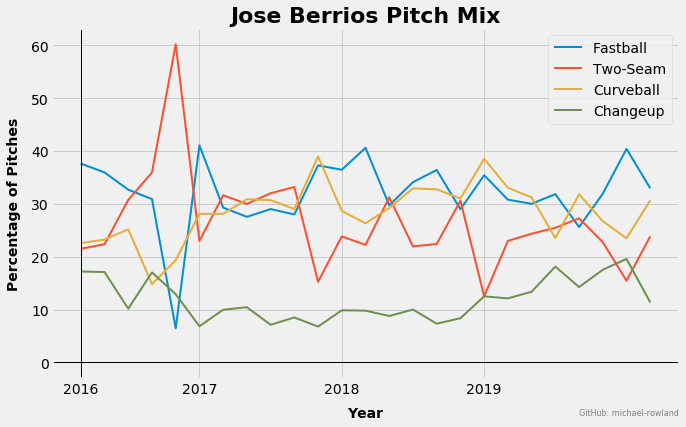

In [275]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(10, 6))

for pitch in plot_data.columns:
  plt.plot(range(len(plot_data)), plot_data[pitch], 
           label=pitch, linewidth=2)

ax.legend()

ax.set_title('Jose Berrios Pitch Mix', fontsize=22, fontweight='bold')
ax.set_xlabel('Year', 
              fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel('Percentage of Pitches', 
              fontsize=14, fontweight='bold', labelpad=10)

ax.set_xticks([0, 5, 11, 17])
ax.set_xticklabels(range(2016, 2020))
ax.set_yticklabels(range(-10,70,10))

ax.axhline(y=0, color='black', linewidth=1)
ax.axvline(x=0, color='black', linewidth=1)
ax.text(x=21, y=-0.1, s='GitHub: michael-rowland', fontsize=8, color='grey')
# plt.savefig('Pitch-Mix.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

Using a simple bar plot, we can see Berrios pitch mix in 2019.

In [0]:
mix = df[df['game_date'].dt.year == 2019]['pitch_type'].value_counts()
mix = mix.rename_axis('pitch_type').reset_index(name='counts')

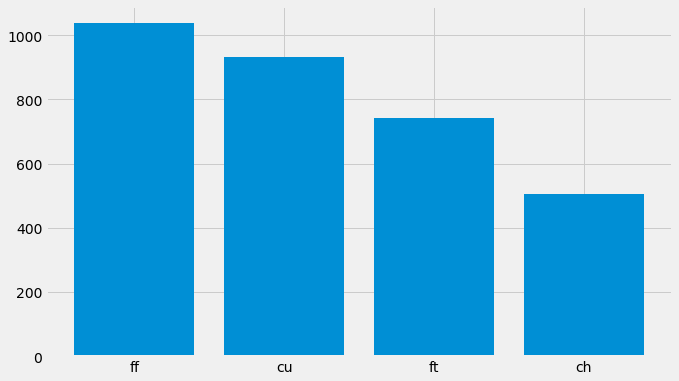

In [277]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(mix['pitch_type'], mix['counts'])
plt.show()

## RANDOM FOREST

---



While this function is not called throughout this notebook, it was useful in tracking model accuracy during development.

In [0]:
def log_model(txt_file='model_log.txt'):
    with open(txt_file, 'a') as file:
        file.write(f'Validation accuracy: {model.score(X_val_processed, y_val):.5f}\n')
        file.write(f'Features: {X_train.columns}\n')
        file.write(f'{model.get_params}\n')
        file.write('\n')
        file.close()

Using a train/test split, we can subdivide the data into training, validation, and testing sets.

In [0]:
train, test = train_test_split(df, train_size=0.8, random_state=42)
train, val = train_test_split(train, train_size=0.8, random_state=42)

In [0]:
target = 'pitch_type'
features = df.columns.drop([target, 'game_date', 'year', 'month'])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [281]:
processor = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean')
)
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)
X_test_processed = processor.transform(X_test)

model = RandomForestClassifier(
                               n_estimators=100, 
                               max_features=16,
                               max_depth=9, 
                               random_state=42, 
                               n_jobs=-1)
model.fit(X_train_processed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features=16,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [282]:
baseline = y_train.value_counts(normalize=True)
print(f'Baseline Accuracy: {baseline[0]:.5f}')
print(f'Train Accuracy: {model.score(X_train_processed, y_train):.5f}')
print(f'Validation Accuracy: {model.score(X_val_processed, y_val):.5f}')

Baseline Accuracy: 0.32381
Train Accuracy: 0.66007
Validation Accuracy: 0.43204


In [283]:
print(f'Test Accuracy: {model.score(X_test_processed, y_test):.5f}')

Test Accuracy: 0.41246


### Random Forest Predictions Visualization

Using a bar chart we can see that this model tends to over predict pitches which are most likely to be thrown, and under predict pitches which are less likely to be thrown.

In [0]:
predictions_df = pd.DataFrame({'True Values': y_val,
                            'Predictions': model.predict(X_val_processed)})
predictions_df = predictions_df.apply(lambda x: x.value_counts())

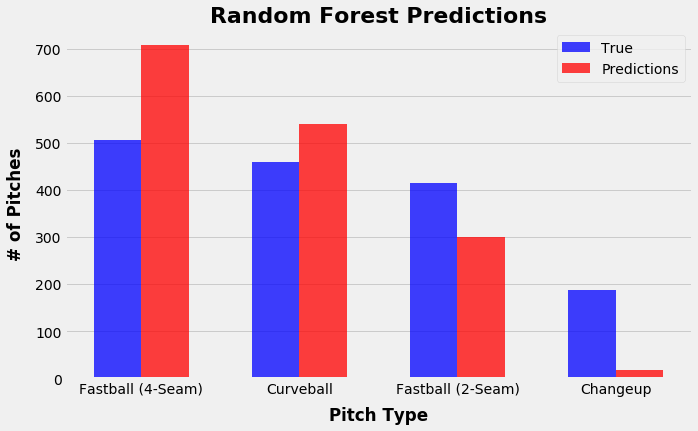

In [285]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(10, 6))

X = np.arange(len(predictions_df['Predictions'].unique()))
bar_width = 0.30

ax.bar(X - bar_width/2, predictions_df['True Values'], 
       color = 'b', width = bar_width, align='center', alpha=0.75, label='True')
ax.bar(X + bar_width/2, predictions_df['Predictions'], 
       color = 'r', width = bar_width, align='center', alpha=0.75, label='Predictions')

ax.legend()

ax.set_xticks(X)
ax.set_xticklabels(['Fastball (4-Seam)', 'Curveball', 'Fastball (2-Seam)', 'Changeup'])

ax.set_title('Random Forest Predictions', fontsize=22, fontweight='bold')
ax.set_xlabel('Pitch Type', fontweight='bold', labelpad=10)
ax.set_ylabel('# of Pitches', fontweight='bold', labelpad=10)
ax.xaxis.grid(False)

# plt.savefig('Predictions.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

## LOGISTIC REGRESSION

---



We have to first do a bit of cleaning/mapping to update our dataframe to include only numeric values.

In [0]:
log_df = df
pitch_mapping = {'ff': 1, 'ft': 1, 'cu': 0, 'ch': 0}
log_df['pitch_type'] = log_df['pitch_type'].map(pitch_mapping)

advantage_mapping = {'behind': -1, 'neutral': 0, 'ahead': 1}
log_df['pitcher_advantage'] = log_df['pitcher_advantage'].map(advantage_mapping)

stance_mapping = {'L': 1, 'R': 0}
log_df['stand'] = log_df['stand'].map(stance_mapping)

bool_cols = ['on_3b', 'on_2b', 'on_1b', 'previous_strike', 'baserunner']
log_df[bool_cols] = log_df[bool_cols].astype(int)

drop_cols = ['game_date', 'previous_zone', 'previous_pitch']
log_df = log_df.drop(drop_cols, axis=1)

for column in log_df.columns:
  isnull = log_df[column].isnull().any()
  if isnull:
    log_df[column] = log_df[column].fillna(0)

In [287]:
baseline = log_df['pitch_type'].value_counts(normalize=True)[1]
print(f'Logistic Regression Baseline: {baseline*100:.2f}%')

Logistic Regression Baseline: 59.38%


In [0]:
target = 'pitch_type'
features = log_df.columns.drop(target)

train, test = train_test_split(log_df, train_size=0.8, random_state=42)
train, val = train_test_split(train, train_size=0.8, random_state=42)

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [289]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
val_accuracy = lr.score(X_val, y_val)
test_accuracy = lr.score(X_test, y_test)
print(f'Baseline Accuracy: {y_train.value_counts(normalize=True)[1]*100:.2f}%')
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')

Baseline Accuracy: 59.67%
Validation Accuracy: 60.50%


In [290]:
 print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Test Accuracy: 59.57%


Here, this simple scatter plot highlights the noise in this data

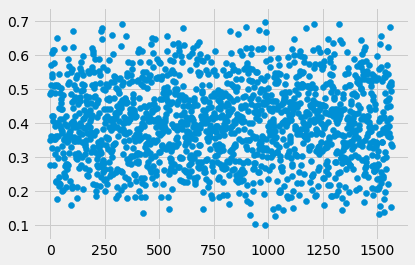

In [291]:
probabilities = lr.predict_proba(X_val)

plt.scatter(range(len(probabilities)), probabilities[:,0])
plt.show()

**Conclusion**

While there is likely room for improvement in model selection, engineering additional useful features, and hyperparameter tuning, it is good to be reminded of the subject of this analysis: Jose Berrios. Berrios is the Minnesota Twins top starting pitcher, and is known for his balanced style, using all four pitches to keep hitters off balance. One of his strengths lies in this unpredictability. It makes sense then, that this seemingly random approach would prove difficult to predict.